In [2]:
import numpy as np
from metavision_core.event_io import RawReader
from matplotlib import pyplot as plt
from metavision_ml.preprocessing import event_cube
from metavision_ml.preprocessing.viz import viz_event_cube_rgb, filter_outliers
from tqdm import tqdm

file = input("Enter the path to the file: ").strip()
record = RawReader(file)
height, width = record.get_size()
dt = 1e6 # 1s in µs
slices = np.arange(100, 33333, 500)
snrs = []
events = record.load_delta_t(dt)
for i, slice_duration in tqdm(enumerate(slices), total=len(slices)):
    n_bins = dt // slice_duration
    volume = np.zeros((1, int(n_bins * 2), int(height//4), int(width//4)), dtype=np.float32)
    event_cube(events, volume, dt, downsampling_factor=2)
    # separate the bins by polarity (0 and 1) for visualization
    # even bins are for polarity 1, odd bins are for polarity 0
    volume_p0 = volume[:, 0::2, :, :]
    volume_p1 = volume[:, 1::2, :, :]
    total_p0 = np.sum(volume_p0, axis=(2, 3)) # sum over the spatial dimensions
    total_p1 = np.sum(volume_p1, axis=(2, 3)) # sum over the spatial dimensions
    # combine the two polarities into a single volume
    volume = total_p1 + total_p0
    mean = np.mean(volume)
    std = np.std(volume)
    snr = mean / std
    snrs.append(snr)



100%|██████████| 67/67 [00:06<00:00, 10.00it/s]


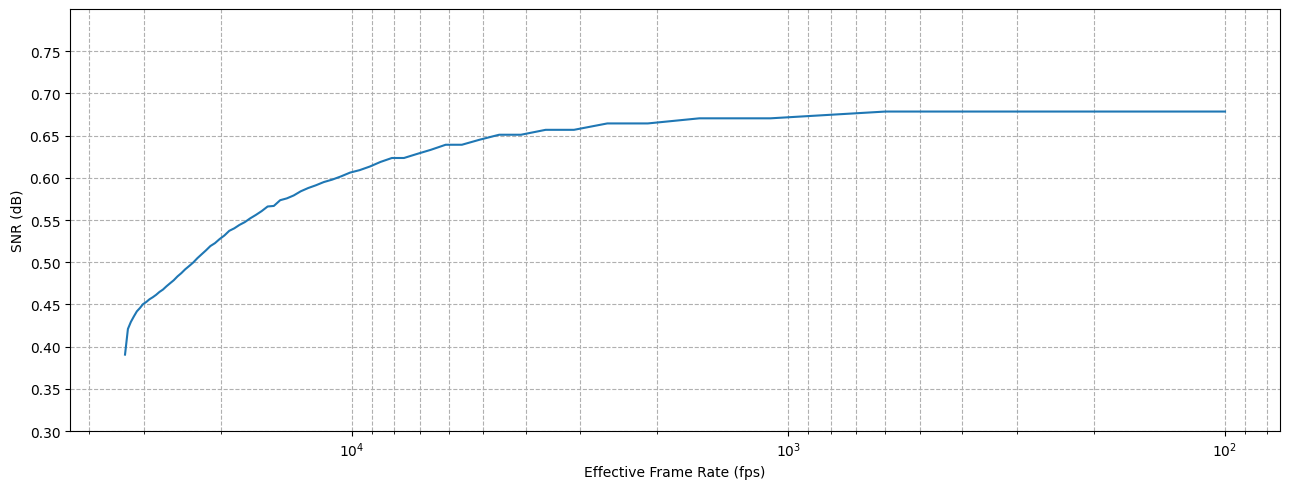

array([10000.        ,  1666.66666667,   909.09090909,   625.        ,
         476.19047619,   384.61538462,   322.58064516,   277.77777778,
         243.90243902,   217.39130435,   196.07843137,   178.57142857,
         163.93442623,   151.51515152,   140.84507042,   131.57894737,
         123.45679012,   116.27906977,   109.89010989,   104.16666667,
          99.00990099,    94.33962264,    90.09009009,    86.20689655,
          82.6446281 ,    79.36507937,    76.33587786,    73.52941176,
          70.92198582,    68.49315068,    66.22516556,    64.1025641 ,
          62.11180124,    60.24096386,    58.47953216,    56.81818182,
          55.24861878,    53.76344086,    52.35602094,    51.02040816,
          49.75124378,    48.54368932,    47.39336493,    46.2962963 ,
          45.24886878,    44.24778761,    43.29004329,    42.37288136,
          41.49377593,    40.6504065 ,    39.84063745,    39.0625    ,
          38.31417625,    37.59398496,    36.900369  ,    36.23188406,
      

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assume snrs and slices are already computed
# Remove any NaN values
snrs = np.array(snrs)
slices = np.array(slices)
valid_indices = ~np.isnan(snrs)
snrs = snrs[valid_indices]
slices = slices[valid_indices]

# Convert SNR to dB
snr_db = 10 * np.log10(snrs)
snr_db = snr_db[::-1]
# Create the plot
plt.figure(figsize=(13, 5))

# Plot the SNR values in dB with x-axis on log scale
plt.plot(slices, snr_db)

# Set x-axis to log scale
plt.xscale('log')

# Convert x-ticks to effective frame rate
effective_frame_rate = 1e6 / slices
# x_ticks = [f"{int(rate)}" for rate in effective_frame_rate]
# reverse the x axis
plt.gca().invert_xaxis()
# Set custom x-ticks
# plt.xticks(slices, x_ticks, rotation=45)
plt.xlabel("Effective Frame Rate (fps)")
plt.ylabel("SNR (dB)")

# Show the y endpoint and increase the y resolution
plt.ylim(0.3, 0.8)
plt.yticks(np.arange(0.3, 0.8, 0.05))

# Display the plot
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
effective_frame_rate